In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)


2.3.0
2.4.3


In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [6]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

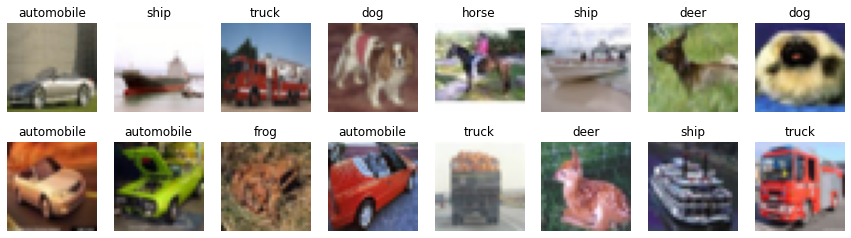

In [7]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### Data Preparation

In [8]:
x_train2 = x_train / 255. - 0.5
x_test2 = x_test / 255. - 0.5

y_train2 = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

### CNN Architecture

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [10]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    
    # CONV 1
    # first layer needs to define "input_shape"
    model.add(Conv2D(16, (3, 3), strides = (1, 1), padding="same", name = 'conv1', input_shape=(32, 32, 3)))   
    model.add(LeakyReLU(0.1))
    
    # CONV 2
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding="same", name = 'conv2'))  
    model.add(LeakyReLU(0.1))
    
    # MaxPooling2D 1
    model.add(MaxPooling2D((2, 2), name='max_pool_1'))
    
    # Dropout
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    # CONV 3
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding="same", name = 'conv3')) 
    model.add(LeakyReLU(0.1))
    
    # CONV 4
    model.add(Conv2D(64, (3, 3), strides = (1, 1), padding="same", name = 'conv4'))  
    model.add(LeakyReLU(0.1))
    
    # MaxPooling2D 1
    model.add(MaxPooling2D((2, 2), name='max_pool_2'))
    
    # Dropout
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    # Flatten
    model.add(Flatten())    
    
    # FC
    model.add(Dense(256, name='fc1'))
    model.add(Dropout(0.5, noise_shape=None, seed=0))
    
    # FC
    model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class    
    model.add(Activation("softmax"))  # output probabilities

    return model

In [11]:
K.clear_session()  # clear default graph
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        9

### Model Training

In [16]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adam(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0
)


Learning rate: 0.005
Learning rate: 0.0045
Learning rate: 0.00405
Learning rate: 0.003645
Learning rate: 0.0032805
Learning rate: 0.00295245
Learning rate: 0.002657205
Learning rate: 0.0023914846
Learning rate: 0.002152336
Learning rate: 0.0019371024


In [17]:
model.save_weights("weights.h5")


In [18]:
model.load_weights("weights.h5")


### Model Evaluation

In [20]:
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

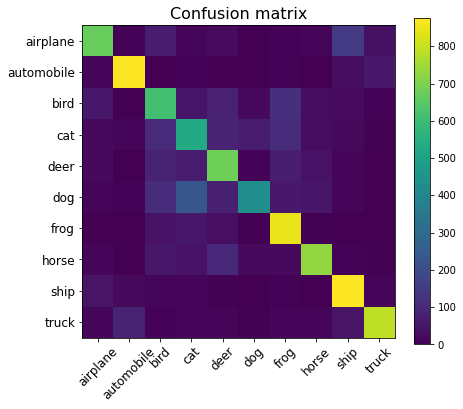

Test accuracy: 0.705


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

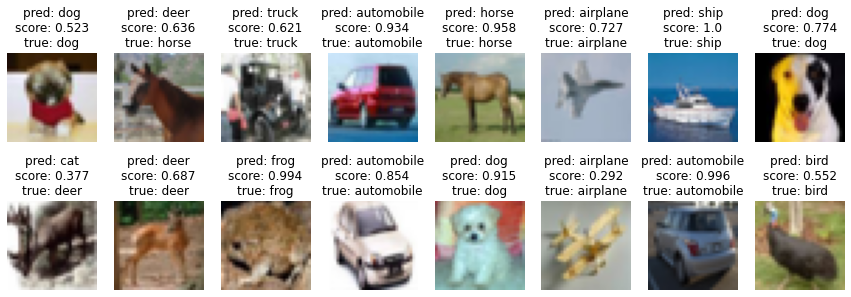

In [22]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()